In [24]:
import pandas as pd
import os
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.feature_selection import VarianceThreshold
from src.utils.data import getDataPandas, getConfig
from pipe.lut import Model_LUT, Metrics_LUT, Feature_LUT, Plot_LUT
from pipe.stats import stats_analyze

In [25]:
# None-image features
data = getDataPandas()

In [37]:
model_config = getConfig('model')
data_config = getConfig('data')
img_config = getConfig('image')
group = data_config['data_group']

In [27]:
# Tasks include models used
TASKS = [
    #'classification/5',
    #'regression',
    'classification/2'
]
# Features include image features used
FEATURES = [
    ['test_radiomic'],
]

In [5]:
# Maybe write to a specific file later?
log_func = print

In [6]:
rst = {}

In [39]:
from mrmr import mrmr_classif, mrmr_regression

Current Task: classification/2

Image Features:
 ['test_radiomic']

SEX chi2 p: 0.5414803876006901
CAT chi2 p: 0.9510706628888684
AGE_AT_VISIT Normaltest p_train: [0.07505303], p_test: [0.48389882]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([1.54953415]), pvalue=array([0.12271054]))
NUPDR3OF Normaltest p_train: [0.01407325], p_test: [0.53859285]
NUPDR3OF ranksums p: RanksumsResult(statistic=array([0.53408144]), pvalue=array([0.59328519]))
LEDD Normaltest p_train: [2.56158925e-12], p_test: [0.1798008]
LEDD ranksums p: RanksumsResult(statistic=array([0.51837316]), pvalue=array([0.60419794]))
DURATION Normaltest p_train: [0.00553476], p_test: [0.13860719]
DURATION ranksums p: RanksumsResult(statistic=array([-0.45554005]), pvalue=array([0.64872076]))



100%|██████████| 15/15 [00:00<00:00, 61.98it/s]


Selected features: ['lSN_gldm_DependenceNonUniformity', 'lCAU_gldm_DependenceVariance', 'rPUT_gldm_DependenceEntropy', 'lCAU_gldm_DependenceNonUniformity', 'lPUT_firstorder_Skewness', 'lSN_gldm_SmallDependenceEmphasis', 'lCAU_firstorder_Minimum', 'lSN_gldm_SmallDependenceHighGrayLevelEmphasis', 'lSN_gldm_SmallDependenceLowGrayLevelEmphasis', 'lCAU_gldm_DependenceEntropy', 'rSN_firstorder_Minimum', 'rCAU_gldm_DependenceNonUniformityNormalized', 'lPUT_gldm_DependenceNonUniformity', 'lSN_firstorder_10Percentile', 'lCAU_firstorder_90Percentile']

Demo + Clinic:

Model: svc
AUC train 0.6896551724137931, test 0.6856060606060606


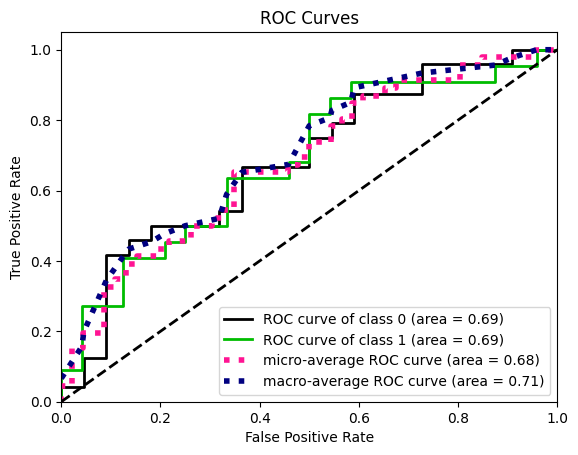

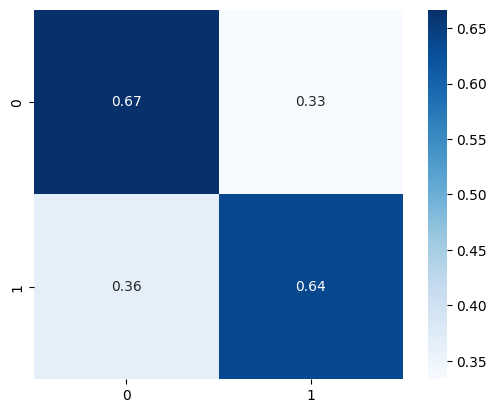

Params {'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 0.01}

Model: xgboost
AUC train 0.9738706228281209, test 0.7386363636363636


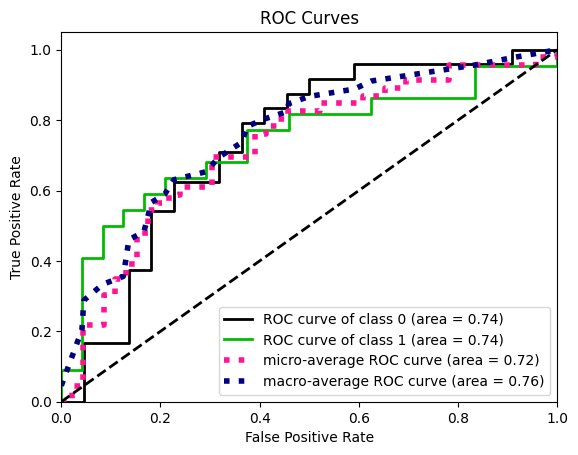

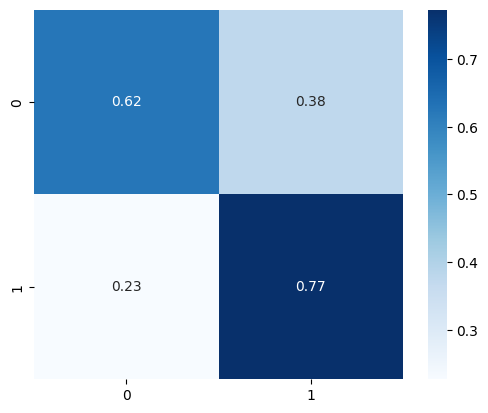

Params {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'missing': -999, 'n_estimators': 25, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.9}


Demo + Img:

Model: svc
AUC train 0.4589681903234429, test 0.3484848484848485


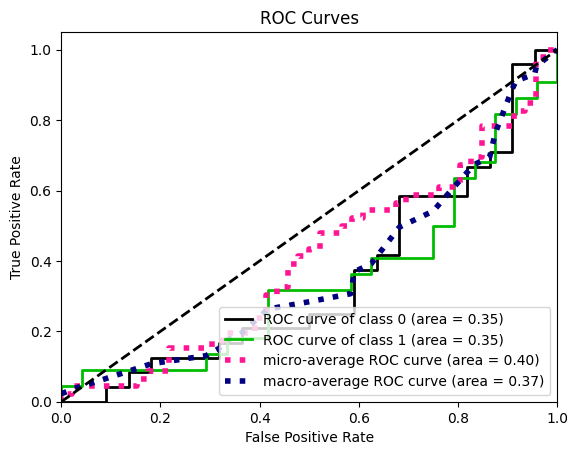

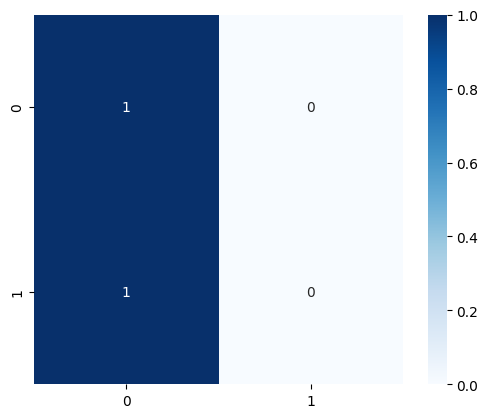

Params {'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 0.001}

Model: xgboost
AUC train 0.9529537556802995, test 0.5852272727272727


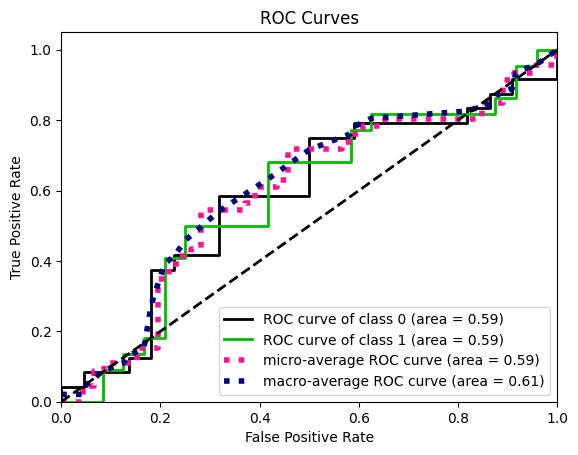

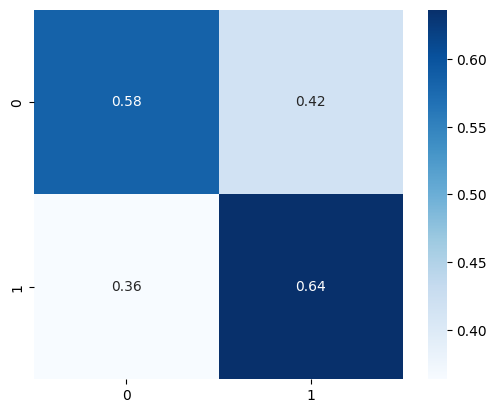

Params {'colsample_bytree': 0.85, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'missing': -999, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.9}


Demo + Clinic + Img:

Model: svc
AUC train 0.7336941994119219, test 0.7386363636363636


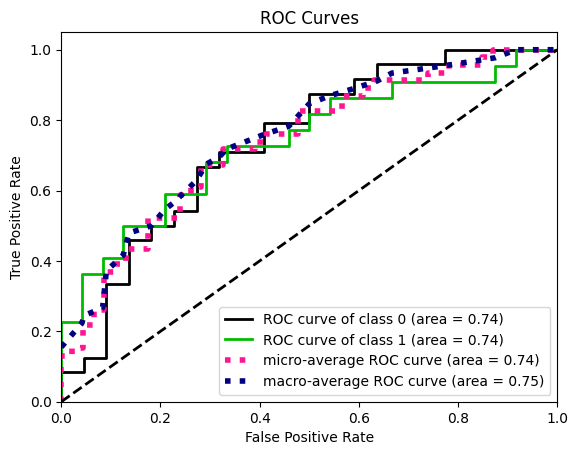

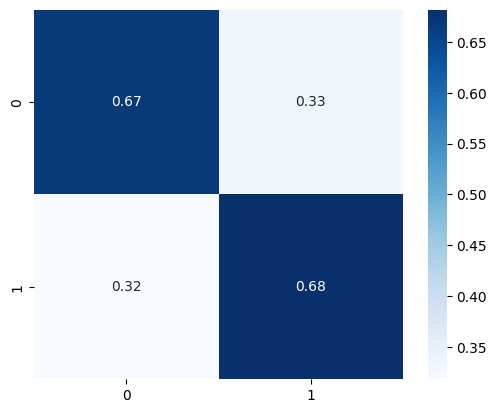

Params {'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 0.01}

Model: xgboost
AUC train 1.0, test 0.7424242424242424


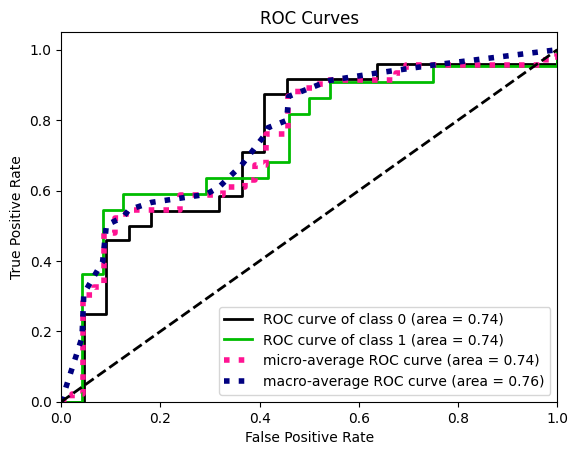

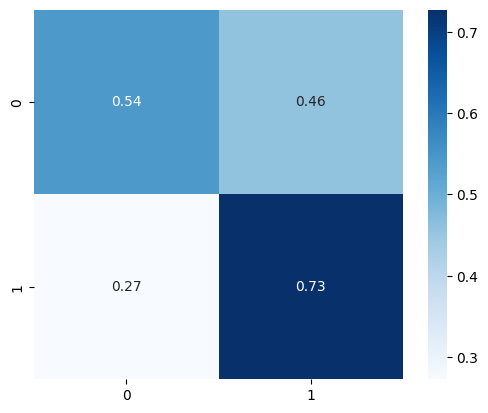

Params {'colsample_bytree': 0.85, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 100, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.85}




In [46]:
# Loop for tasks and feature collections
for task_name in TASKS:
    log_func('Current Task: {}'.format(task_name))
    log_func()
    for feature_names in FEATURES:
        log_func('Image Features:\n {}'.format(feature_names))
        log_func()
        # Get model list
        task = model_config['task'][task_name]
        models = task['models']
        metric_list = task['metrics']
        
        # Filter data with demographic and clinical keys
        x = data[group['demo'] + group['clinic']]
        y = data[[task['output']]]
        # Split the dataset
        train_inds = data_config['train_index']
        test_inds = data_config['test_index']
        x_clinic_train = x.iloc[train_inds].reset_index(drop=True)
        x_clinic_test = x.iloc[test_inds].reset_index(drop=True)
        y_train = y.iloc[train_inds].reset_index(drop=True)
        y_test = y.iloc[test_inds].reset_index(drop=True)
        # Statistical Analysis
        stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
        # Empty dataframes to fill with image features
        x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
        x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

        # Loop to calculate each feature, multiple features are supported
        for feature_name in feature_names:
            # Get calculation function and params via LUT
            func = Feature_LUT[feature_name]
            params = img_config['task'][feature_name]['params']
            # Calculate features and append to the dataframe
            x_fe_train, x_fe_test = func(data, train_inds, test_inds, params)
            x_img_train = x_img_train.join(x_fe_train.reset_index(drop=True))
            x_img_test = x_img_test.join(x_fe_test.reset_index(drop=True))

        ## Feature Selection
        ## WIP
        
        #isContinuous = task['continuous']
        
        #mRMR
        #selected = mrmr_classif(X=x_img_train, y=y_train, K=20) if isContinuous else mrmr_regression(X=x_img_train, y=y_train, K=20)
        selected = mrmr_classif(X=x_img_train, y=y_train, K=15)
        log_func('Selected features: {}'.format(selected))
        log_func()
        x_img_train = x_img_train[selected]
        x_img_test = x_img_test[selected]

        # Rearrange data
        # demo + clinic, demo + img, demo + clinic + img
        x_clinic_train = x_clinic_train.reset_index(drop=True)
        x_clinic_test = x_clinic_test.reset_index(drop=True)
        x_demo_train = x_clinic_train[group['demo']]
        x_demo_test = x_clinic_test[group['demo']]
        x_clinic_img_train = x_clinic_train.join(x_img_train)
        x_clinic_img_test = x_clinic_test.join(x_img_test)
        # No demo data in img df
        x_img_train = x_demo_train.join(x_img_train)
        x_img_test = x_demo_test.join(x_img_test)

        x_train_list = [x_clinic_train, x_img_train, x_clinic_img_train]
        x_test_list = [x_clinic_test, x_img_test, x_clinic_img_test]
        info_list = ['Demo + Clinic:', 'Demo + Img:', 'Demo + Clinic + Img:']

        # Loop
        for i in range(3):
            x_train = x_train_list[i]
            x_test = x_test_list[i]
            log_func(info_list[i])
            log_func()
            for model in models:
                name = model['name']
                parameters = model['params']
                model = Model_LUT[name]()
                cv = GridSearchCV(
                    model,
                    parameters,
                    n_jobs=5,
                    # StratifiedGroupKFold?
                    cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                    scoring=task['gridsearch_params']['scoring']
                )
                cv.fit(x_train, y_train.values.ravel())
                best = cv.best_estimator_
                log_func('Model: {}'.format(name))
                # Now classification specific, other metrics need to be considered according to task
                for metric in metric_list:
                    metric_func = Metrics_LUT[metric[0]]
                    # predict_proba True
                    # predic        False
                    pred_func = best.predict_proba if metric[1] else best.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    # TODO: multiclass support should be implemented via metric_func
                    log_func('{} train {}, test {}'.format(metric[0],
                                                           metric_func(y_train[task['output']].to_numpy(), train_pred),
                                                           metric_func(y_test[task['output']].to_numpy(), test_pred)
                                                           ))
                plot_list = task['plot']
                for plot in plot_list:
                    plot_func = Plot_LUT[plot[0]]
                    pred_func = best.predict_proba if plot[1] else best.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    plot_func(y_test[task['output']].to_numpy(), test_pred)
                    plt.show()
                log_func('Params {}'.format(cv.best_params_)) # best.get_params()
                log_func()
            log_func()

In [42]:
selected

['lPUT_firstorder_Skewness',
 'lCAU_firstorder_Minimum',
 'rSN_firstorder_Minimum',
 'lSN_firstorder_10Percentile',
 'lCAU_firstorder_90Percentile',
 'lPUT_firstorder_Kurtosis',
 'lCAU_firstorder_Skewness',
 'rPUT_firstorder_Minimum',
 'rCAU_firstorder_10Percentile',
 'lCAU_firstorder_Mean',
 'rCAU_firstorder_Skewness',
 'lSN_firstorder_Energy',
 'rCAU_firstorder_Kurtosis',
 'lCAU_firstorder_RootMeanSquared',
 'rSN_firstorder_10Percentile',
 'lCAU_firstorder_10Percentile',
 'lCAU_firstorder_Median',
 'lSN_firstorder_TotalEnergy',
 'lPUT_firstorder_Median',
 'lCAU_firstorder_Kurtosis']

In [44]:
selected

['lSN_gldm_DependenceNonUniformity',
 'lCAU_gldm_DependenceVariance',
 'rPUT_gldm_DependenceEntropy',
 'lCAU_gldm_DependenceNonUniformity',
 'lPUT_firstorder_Skewness',
 'lSN_gldm_SmallDependenceEmphasis',
 'lCAU_firstorder_Minimum',
 'lSN_gldm_SmallDependenceHighGrayLevelEmphasis',
 'lSN_gldm_SmallDependenceLowGrayLevelEmphasis',
 'lCAU_gldm_DependenceEntropy',
 'rSN_firstorder_Minimum',
 'rCAU_gldm_DependenceNonUniformityNormalized',
 'lPUT_gldm_DependenceNonUniformity',
 'lSN_firstorder_10Percentile',
 'lCAU_firstorder_90Percentile',
 'lPUT_firstorder_Kurtosis',
 'lCAU_firstorder_Skewness',
 'rPUT_firstorder_Minimum',
 'rCAU_firstorder_10Percentile',
 'lCAU_firstorder_Mean']